In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

df = pd.read_csv("codope_data camp2.csv") 
df

,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb,Yb PLQY(%),Er PLQY(%),Batch
0,26.8,240,27,1.3,2.4,1.8,70,22,0
1,23.9,252,2,1.0,3.1,1.9,38,13,0
2,21.6,227,24,0.8,2.1,2.3,55,22,0
3,13.7,235,16,1.1,2.6,3.7,75,18,0
4,9.5,266,6,1.0,2.1,2.9,16,1,0
5,7.4,243,6,0.7,1.7,2.3,57,26,0
6,11.6,221,19,0.8,3.5,1.6,77,11,0
7,19.2,229,9,1.2,3.9,2.7,62,22,0
8,28.0,249,22,0.9,2.9,3.6,45,40,0
9,6.9,256,15,1.2,3.8,3.1,2,0,0


In [3]:
df.columns

Index(['DGPAM ligands amount (mg)', 'Reaction temperature(C)',
       'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', 'Yb PLQY(%)',
       'Er PLQY(%)', 'Batch'],
      dtype='object')

# Data Analysis

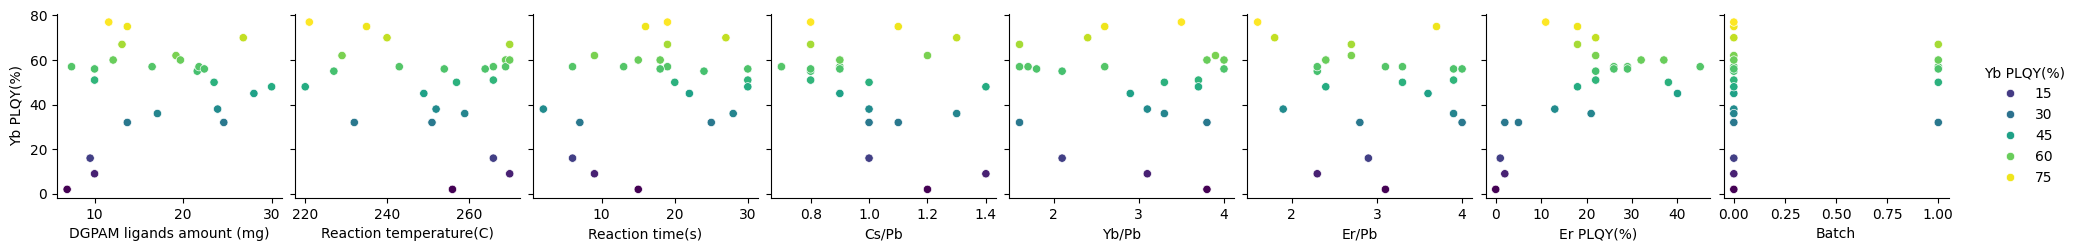

In [5]:
sb.pairplot(df, 
            y_vars=['Yb PLQY(%)'], 
            hue='Yb PLQY(%)', palette='viridis'
           )

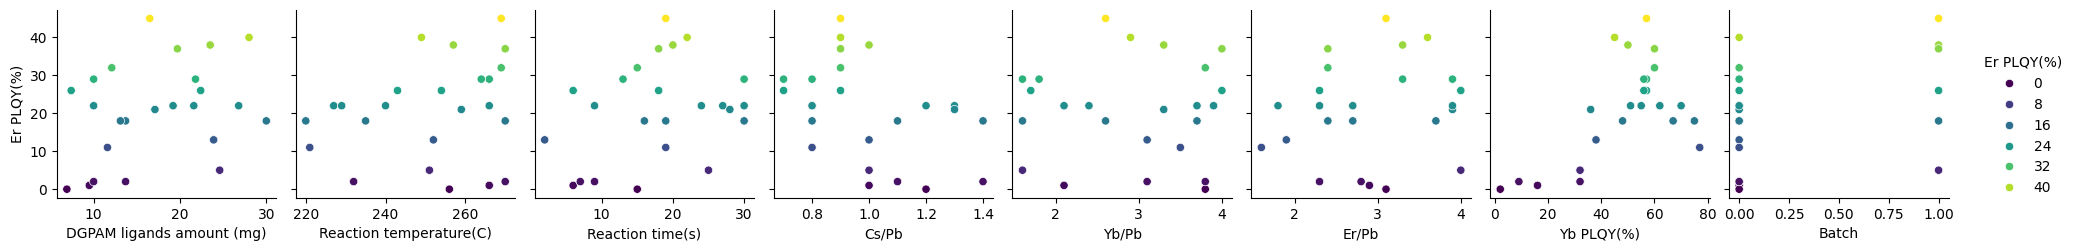

In [8]:
sb.pairplot(df, 
            y_vars=['Er PLQY(%)'], 
            hue='Er PLQY(%)', palette='viridis'
           )

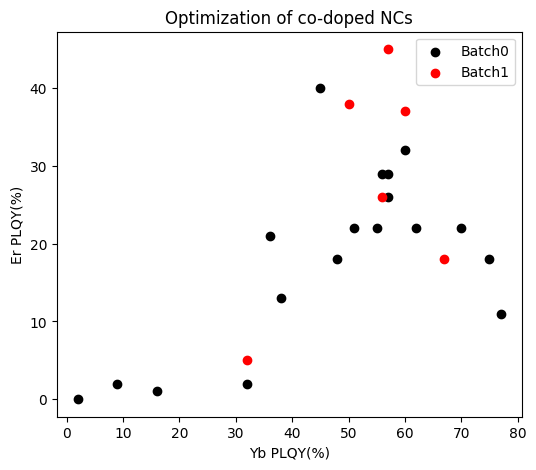

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.scatter(df['Yb PLQY(%)'][df['Batch']==0], df['Er PLQY(%)'][df['Batch']==0], c='k', label='Batch0')
axs.scatter(df['Yb PLQY(%)'][df['Batch']==1], df['Er PLQY(%)'][df['Batch']==1], c='r', label='Batch1')
#axs.scatter(df['Yb PLQY(%)'][df['Batch']==2], df['Er PLQY(%)'][df['Batch']==2], c='b', label='Batch2')

axs.set_ylabel('Er PLQY(%)')
axs.set_xlabel('Yb PLQY(%)')
axs.set_title('Optimization of co-doped NCs')
plt.legend()

# Optimization

In [14]:
import torch
import botorch
import warnings

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

from botorch import fit_gpytorch_mll

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement

# qNEI specific
from botorch.acquisition import qLogNoisyExpectedImprovement

# utilities
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

from sklearn.metrics import mean_squared_error, r2_score


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": device} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)
print(f'BoTorch version {botorch.__version__}')

BoTorch version 0.15.1


In [15]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([0, df['Er PLQY(%)'].max()*0.8], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

lower_bounds = torch.tensor([5.0, 220.0, 1.0, 0.6, 1.5, 1.5], **tkwargs) 
upper_bounds = torch.tensor([30.0, 270.0, 30.0, 1.4, 4, 4.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

In [16]:
####################
# model fitting

train_x = df[['DGPAM ligands amount (mg)', 'Reaction temperature(C)', 'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb', ]].to_numpy()
train_x = torch.tensor(train_x, **tkwargs)
train_x_gp = normalize(train_x, problem_bounds)

train_y = df[['Yb PLQY(%)', 'Er PLQY(%)']].to_numpy()
train_y = torch.tensor(train_y, **tkwargs)

models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll, optimizer_kwargs={"options": {"maxiter": 50}});

In [17]:
with torch.no_grad():

    posterior = model.posterior(train_x_gp)
    means = posterior.mean.cpu().numpy()
    variances = posterior.variance.cpu().numpy()

df['Pred Yb PLQY(%)'] = means[:,0]
df['Pred Er PLQY(%)'] = means[:,1]
df['Var Yb PLQY(%)'] = variances[:,0]
df['Var Er PLQY(%)'] = variances[:,1]
df['CI Yb PLQY(%)'] = 1.96 * np.sqrt(df['Var Yb PLQY(%)'])
df['CI Er PLQY(%)'] = 1.96 * np.sqrt(df['Var Er PLQY(%)'])

df

,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb,Yb PLQY(%),Er PLQY(%),Batch,Pred Yb PLQY(%),Pred Er PLQY(%),Var Yb PLQY(%),Var Er PLQY(%),CI Yb PLQY(%),CI Er PLQY(%)
0,26.8,240,27,1.3,2.4,1.8,70,22,0,69.696744,21.969466,2.431096,1.065619,3.056026,2.023285
1,23.9,252,2,1.0,3.1,1.9,38,13,0,38.070274,12.991619,2.442260,1.065406,3.063036,2.023082
2,21.6,227,24,0.8,2.1,2.3,55,22,0,54.994316,21.959824,2.438844,1.064149,3.060892,2.021888
3,13.7,235,16,1.1,2.6,3.7,75,18,0,74.592787,17.967491,2.429254,1.064746,3.054868,2.022456
4,9.5,266,6,1.0,2.1,2.9,16,1,0,16.150167,1.076556,2.431341,1.064588,3.056180,2.022305
5,7.4,243,6,0.7,1.7,2.3,57,26,0,56.877515,25.954285,2.440512,1.065936,3.061939,2.023586
6,11.6,221,19,0.8,3.5,1.6,77,11,0,76.908229,11.056879,2.440333,1.064618,3.061827,2.022334
7,19.2,229,9,1.2,3.9,2.7,62,22,0,61.823829,21.869653,2.428155,1.063619,3.054177,2.021385
8,28.0,249,22,0.9,2.9,3.6,45,40,0,44.913598,39.872860,2.413285,1.058065,3.044811,2.016100
9,6.9,256,15,1.2,3.8,3.1,2,0,0,2.400137,0.154300,2.433734,1.064470,3.057684,2.022194


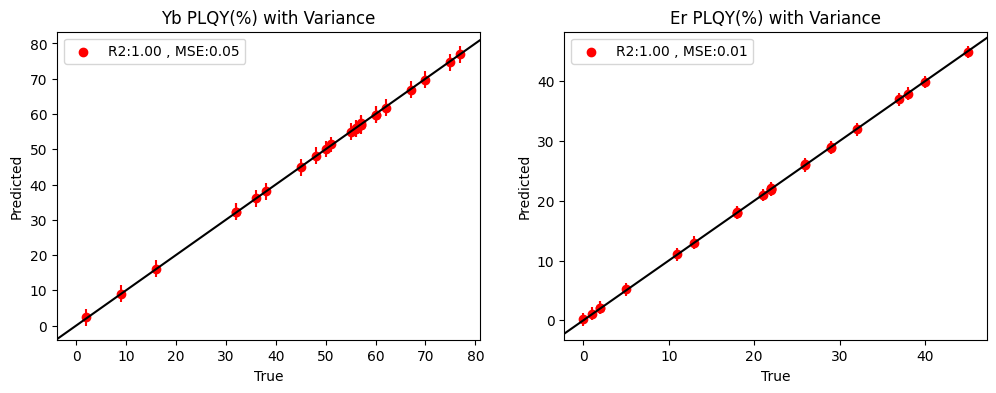

In [18]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, objective in enumerate(['Yb PLQY(%)', 'Er PLQY(%)']):
    ax = axes[i]
    
    r2 = r2_score(
        df[f'{objective}'], df[f'Pred {objective}'])
    mse = mean_squared_error(
        df[f'{objective}'], df[f'Pred {objective}'])

    ax.errorbar(
        df[f'{objective}'], df[f'Pred {objective}'], 
        yerr=df[f'Var {objective}'], 
        linestyle='none', fmt='', color='r')
    ax.scatter(
        df[f'{objective}'], df[f'Pred {objective}'],
        color='r',
        label=f'R2:{r2:.2f} , MSE:{mse:.2f}'
    )
    
    ax.axline((0, 0), slope=1, color='k', linestyle='-')
    ax.set_title(f'{objective} with Variance')
    ax.set(xlabel=f'True', ylabel=f'Predicted')
    ax.legend()

In [ ]:
# checking the Cs/Pb normalized ranges to determine constraint cutoffs

np.hstack([
    train_x_gp[:,5].unsqueeze(1).cpu().numpy(),
    df[['Er/Pb']].to_numpy()
])

In [21]:
####################    
# acquisition function

NUM_RESTARTS = 10
RAW_SAMPLES = 256
BATCH_SIZE = 6
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))
random_state = 45

acq_func = qLogNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point,
    X_baseline=train_x_gp,
    sampler=sampler, 
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(n_obj).tolist()),
    prune_baseline=True, cache_pending=True) 

'''
inequality_constraints (list[tuple[Tensor, Tensor, float]] | None) – 
A list of tuples (indices, coefficients, rhs), with each tuple encoding an inequality constraint of the form 
sum_i (X[indices[i]] * coefficients[i]) >= rhs. indices and coefficients should be torch tensors. 

equality constraint of the form sum_i (X[indices[i]] * coefficients[i]) = rhs
'''

# optimize
candidates, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=standard_bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
    options={"batch_limit": 5, "maxiter": 200},
    sequential=True,
    #inequality_constraints=[
    #(torch.tensor([1.], dtype=torch.int),torch.tensor([1.], dtype=torch.double, device=device),0.68,), # temperature above 254C
    #(torch.tensor([2.], dtype=torch.int),torch.tensor([1.], dtype=torch.double, device=device),0.68,), # time above 20sec
    #(torch.tensor([3.], dtype=torch.int),torch.tensor([-1.], dtype=torch.double, device=device),0.375,), # Cs/Pb below 0.9
    #(torch.tensor([4.], dtype=torch.int),torch.tensor([1.], dtype=torch.double, device=device),0.44,), # Yb/Pb above 2.6   
    #(torch.tensor([4.], dtype=torch.int),torch.tensor([-1.], dtype=torch.double, device=device),0.68,), # Yb/Pb below 3.2
    #(torch.tensor([5.], dtype=torch.int),torch.tensor([1.], dtype=torch.double, device=device),0.64,), # Er/Pb above 3.1
#],
)

In [22]:
#candidates_all = torch.vstack([candidates, candidate1, candidate2])
candidates_all = candidates
candidates_all

tensor([[0.408, 0.312, 0.637, 0.415, 0.621, 0.597],
        [1.000, 1.000, 0.646, 0.411, 0.604, 0.608],
        [0.322, 0.676, 0.682, 0.399, 0.807, 0.626],
        [0.431, 0.174, 0.586, 0.435, 0.338, 0.581],
        [0.322, 0.121, 0.664, 0.378, 0.798, 0.637],
        [0.446, 0.644, 0.627, 0.434, 0.293, 0.505]], device='cuda:0',
       dtype=torch.float64)

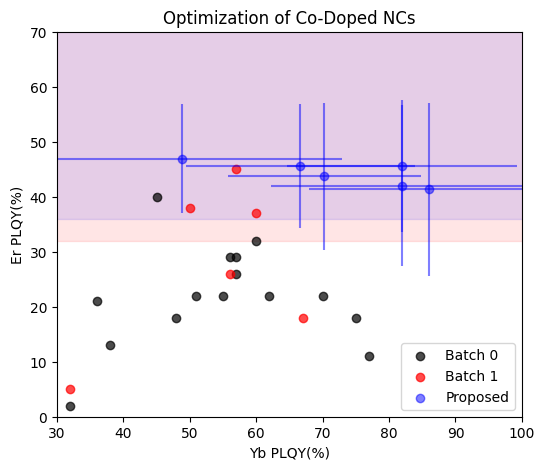

In [38]:
import matplotlib.patches as patches

with torch.no_grad():
    posterior = model.posterior(candidates_all)  
    y_pred = posterior.mean.squeeze()
    y_var = posterior.variance


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(0, df['Er PLQY(%)'].max()*0.8, #label='Batch1 (ref)', 
           marker='*', c='r', alpha=0.7, s=100)
#ax.scatter(40, 30, #label='Batch2 (ref)',
#           marker='*', c='b', alpha=0.7, s=100)
#ax.scatter(40, 35, #label='Batch3 (ref)',
#           marker='*', c='g', alpha=0.7, s=100)



rect = patches.Rectangle((0, df[df['Batch']==0]['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
ax.add_patch(rect)
rect = patches.Rectangle((0, df['Er PLQY(%)'].max()*0.8), 120, 80, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
ax.add_patch(rect)


ax.scatter(train_y[:,0].cpu().numpy()[df['Batch']==0],
           train_y[:,1].cpu().numpy()[df['Batch']==0],
           label=f'Batch 0', c='k', alpha=0.7)

ax.scatter(train_y[:,0].cpu().numpy()[df['Batch']==1],
           train_y[:,1].cpu().numpy()[df['Batch']==1],
           label=f'Batch 1', c='r', alpha=0.7)

ax.errorbar(y_pred.cpu().numpy()[:,0], y_pred.cpu().numpy()[:,1],
            xerr = 1.96*np.sqrt(y_var.cpu().numpy()[:,0]),
            yerr = 1.96*np.sqrt(y_var.cpu().numpy()[:,1]),
           linestyle='none', fmt='', c='b',alpha=0.5)

ax.scatter(y_pred.cpu().numpy()[:,0], y_pred.cpu().numpy()[:,1],
           label=f"Proposed", c='b',alpha=0.5)


ax.set_xlim(30, 100.0)
ax.set_ylim(0, 70.0)

ax.set_xlabel('Yb PLQY(%)')
ax.set_ylabel('Er PLQY(%)')
ax.set_title('Optimization of Co-Doped NCs')
ax.legend()

In [34]:
new_x = unnormalize(candidates_all.detach(), bounds=problem_bounds)
new_x

df_new = pd.DataFrame(
    new_x.cpu().numpy(),
    columns=['DGPAM ligands amount (mg)', 'Reaction temperature(C)', 'Reaction time(s)', 'Cs/Pb', 'Yb/Pb', 'Er/Pb',])
df_new

,DGPAM ligands amount (mg),Reaction temperature(C),Reaction time(s),Cs/Pb,Yb/Pb,Er/Pb
0,15.195132,235.575061,19.469366,0.932047,3.052384,2.991694
1,30.000000,270.000000,19.722281,0.928832,3.009325,3.019674
2,13.039166,253.783990,20.786987,0.919061,3.517981,3.064963
3,15.763852,228.721214,17.990531,0.948085,2.344407,2.953279
4,13.044022,226.036814,20.255885,0.902519,3.495110,3.092338
5,16.156802,252.215852,19.192486,0.947289,2.232105,2.762784


In [40]:
df_new.to_csv('camp2_batch2_proposed.csv')

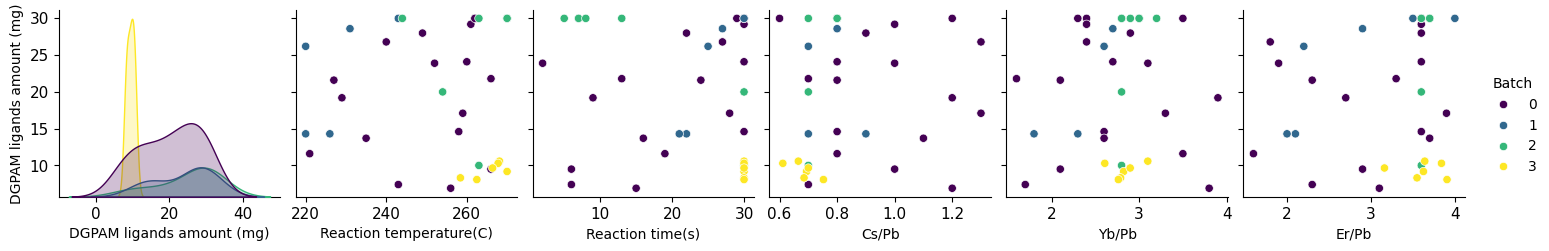

In [117]:
df_new['Batch'] = 1

df_all = pd.concat([df[df_new.columns], df_new], axis=0)
sb.pairplot(df_all, 
            y_vars=['DGPAM ligands amount (mg)'], 
            hue='Batch', palette='viridis'
           )